# About the DonorsChoose Data Set

 - https://www.kaggle.com/c/donorschoose-application-screening

The goal of the DonorsChoose competition is to build a model that can accurately predict whether a teacher's project proposal was accepted, based on the data they provided in their application. The `train.csv` data set provided by 
DonorsChoose contains the following features:

Feature | Description | Data Type
----------|---------------|------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   | string
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> | string
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  | string
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  | string
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`| string
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> | string
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> | string
**`project_essay_1`**    | First application essay<sup>*</sup>  | string
**`project_essay_2`**    | Second application essay<sup>*</sup> | string
**`project_essay_3`**    | Third application essay<sup>*</sup> | string
**`project_essay_4`**    | Fourth application essay<sup>*</sup> | string
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   | int64
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  | string
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  | string
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` | int64

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description | Data Type
----------|---------------|------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   | string
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   | string
**`quantity`** | Quantity of the resource required. **Example:** `3`   | string
**`price`** | Price of the resource required. **Example:** `9.95`   | string

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description | Data Type
----------|---------------|------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved. | int64

## Notes on the Essay Data

Prior to May 17, 2016, the prompts for the essays were as follows:

* **`project_essay_1`**: "Introduce us to your classroom"
* **`project_essay_2`**: "Tell us more about your students"
* **`project_essay_3`**: "Describe how your students will use the materials you're requesting"
* **`project_essay_4`**: "Close by sharing why your project will make a difference"

Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:

* **`project_essay_1`**: "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."
* **`project_essay_2`**: "About your project: How will these materials make a difference in your students' learning and improve their school lives?"

For all projects with `project_submitted_datetime` of 2016-05-17 and later, the values of **project_essay_3** and **project_essay_4** will be `NaN`.

In [517]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns

import numpy as np
import datetime
import lightgbm as lgb
import pandas_profiling as pp
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))

import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [518]:
train = pd.read_csv('train.csv', parse_dates=['project_submitted_datetime'])
test = pd.read_csv('test.csv', parse_dates=['project_submitted_datetime'])
resources = pd.read_csv('resources.csv')
submission = pd.read_csv('sample_submission.csv')

## Data Analysis

In [519]:
train.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1


In [520]:
resources.head()

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [521]:
pp.ProfileReport(resources[['quantity', 'price']])

Number of variables,2
Number of observations,1541272
Total Missing (%),0.0%
Total size in memory,23.5 MiB
Average record size in memory,16.0 B
Numeric,2
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


## Optimising Memory Footprint

In [522]:
resources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541272 entries, 0 to 1541271
Data columns (total 4 columns):
id             1541272 non-null object
description    1540980 non-null object
quantity       1541272 non-null int64
price          1541272 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 47.0+ MB


In [523]:
resources.describe()

,quantity,price
count,1.541272e+06,1.541272e+06
mean,2.860509e+00,5.028398e+01
std,7.570345e+00,1.447326e+02
min,1.000000e+00,0.000000e+00
25%,1.000000e+00,7.900000e+00
50%,1.000000e+00,1.499000e+01
75%,2.000000e+00,3.980000e+01
max,8.000000e+02,9.999000e+03


**Dont need such large datatypes and can downcast to smaller values
quantity (a int) 1 to 800 and price (a float) 0 to 9999.0**

In [524]:
#dont need such large datatypes and can downcast to smaller values
#quantity 1 to 800 and price 0 to 9999.0
data_types = ["uint8","int8","int16","uint16"]
for it in data_types:
    print(np.iinfo(it))

Machine parameters for uint8
---------------------------------------------------------------
min = 0
max = 255
---------------------------------------------------------------

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------

Machine parameters for uint16
---------------------------------------------------------------
min = 0
max = 65535
---------------------------------------------------------------



In [525]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

resources_int = resources.select_dtypes(include=['int'])
converted_int = resources_int.apply(pd.to_numeric,downcast='unsigned')

print(mem_usage(resources_int))
print(mem_usage(converted_int))

compare_ints = pd.concat([resources_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

11.76 MB
2.94 MB


,before,after
uint16,NaN,1.0
int64,1.0,NaN


**Reduction of 75% in memory usage.  Repeat for the float column**

In [526]:
resources_float = resources.select_dtypes(include=['float'])
converted_float = resources_float.apply(pd.to_numeric,downcast='float')

print(mem_usage(resources_float))
print(mem_usage(converted_float))

compare_floats = pd.concat([resources_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

11.76 MB
5.88 MB


,before,after
float32,NaN,1.0
float64,1.0,NaN


**Float column converted from float64 to float32 giving 50% reduction in memory usage.  Replace quantity and price data types  **

In [527]:
#resources["quantity"] = converted_int
#resources["price"] = converted_float

In [528]:
resources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541272 entries, 0 to 1541271
Data columns (total 4 columns):
id             1541272 non-null object
description    1540980 non-null object
quantity       1541272 non-null int64
price          1541272 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 47.0+ MB


** Reduced memory footprint **

In [529]:
pp.ProfileReport(train[['teacher_id', 'teacher_prefix', 'school_state', 'project_grade_category', 'teacher_number_of_previously_posted_projects', 'project_is_approved']])

Number of variables,6
Number of observations,182080
Total Missing (%),0.0%
Total size in memory,8.3 MiB
Average record size in memory,48.0 B
Numeric,1
Categorical,4
Boolean,1
Date,0
Text (Unique),0
Rejected,0


**train overview**:
- There are numerical, categorical, text and date
- Only teacher prefix column has missing values
- project_essay_3 and project_essay_4 columns also have missing values
- Some texts have '\n' and '\r' symbols
- Several categorical features have a lot of unique values
- Some teachers have submitted more than 70 projects
- 10183 rows are duplicate

## Feature Analysis

For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.  Old essays 1 and 2 became new essay 1 and old essays 3 and 4 became new essay 2.  

In [530]:
train.project_submitted_datetime.dt.date[:10]

0    2016-11-18
1    2017-04-26
2    2017-01-01
3    2016-08-12
4    2016-08-06
5    2016-11-05
6    2016-08-31
7    2016-08-03
8    2016-09-13
9    2016-09-24
Name: project_submitted_datetime, dtype: object

In [531]:
old_time = (train.project_submitted_datetime.dt.date < datetime.date(2016, 5, 7))
new_time = (train.project_submitted_datetime.dt.date >= datetime.date(2016, 5, 7))
print('Projects before 2016-05-17:', np.sum(old_time))
print('Projects after 2016-05-17:', np.sum(new_time))
print("Percentage of old essay format in total: {:.1f} percent".format((np.sum(old_time)/np.sum(new_time)*100)))

Projects before 2016-05-17: 3751
Projects after 2016-05-17: 178329
Percentage of old essay format in total: 2.1 percent


**Lets combine the essays and drop the old format**

In [532]:
train.loc[old_time, 'project_essay_1'] = train.loc[old_time, 'project_essay_1'] + ' ' + train.loc[old_time, 'project_essay_2']
train.loc[old_time, 'project_essay_2'] = train.loc[old_time, 'project_essay_3'] + ' ' + train.loc[old_time, 'project_essay_4']
train.drop(['project_essay_3', 'project_essay_4'], axis=1, inplace=True)

In [533]:
train.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,My students need 6 Ipod Nano's to create and d...,26,1
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,My students need matching shirts to wear for d...,1,0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,My students need the 3doodler. We are an SEM s...,5,1
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",My students need balls and other activity equi...,16,0
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,My students need a water filtration system for...,42,1


**Some of the project essay text contains '\\r' and '\\n' lets replace these with a space**

In [534]:
train.project_essay_1 = train.project_essay_1.apply(lambda x: x.replace('\\r', ' ').replace('\\n', ' ').replace('  ', ' '))
train.project_essay_2 = train.project_essay_2.apply(lambda x: x.replace('\\r', ' ').replace('\\n', ' ').replace('  ', ' '))

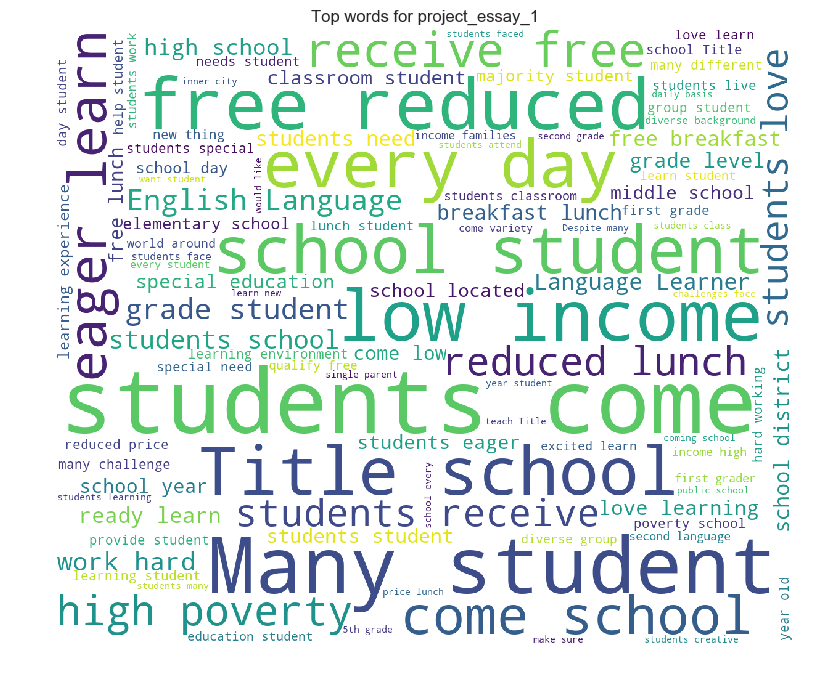

In [535]:
text = ' '.join(train['project_essay_1'].values)
wordcloud = WordCloud(max_font_size=None, stopwords=stop, max_words = 100,background_color='white',
                      width=1200, height=1000).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.title('Top words for project_essay_1')
plt.axis("off")
plt.show();

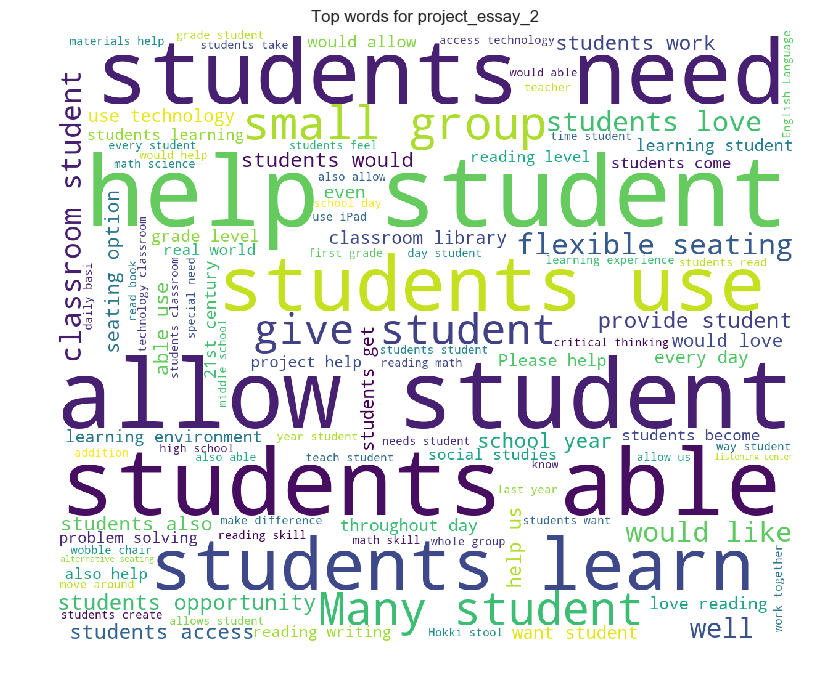

In [536]:
text = ' '.join(train['project_essay_2'].values)
wordcloud = WordCloud(max_font_size=None, stopwords=stop, max_words=100,background_color='white',
                      width=1200, height=1000).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.title('Top words for project_essay_2')
plt.axis("off")
plt.show();

## Project resource summary

In [537]:
train['project_resource_summary'] = train['project_resource_summary'].apply(lambda x: x.replace('\\r', ' ').replace('\\n', ' ').replace('  ', ' '))

<Figure size 1200x800 with 0 Axes>

Text(0.5,1,'Top words for approved projects')

(-0.5, 1199.5, 999.5, -0.5)

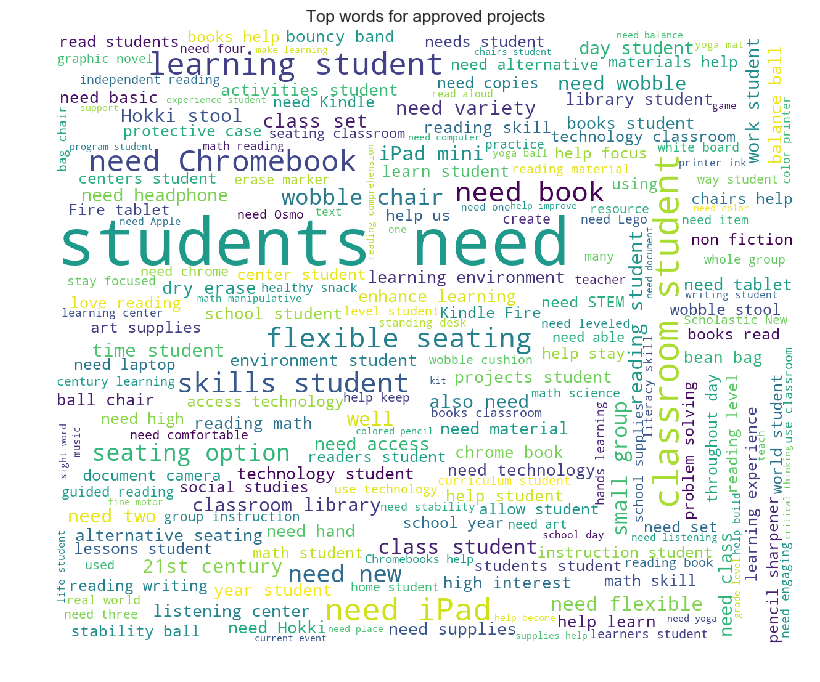

In [538]:
text = ' '.join(train.loc[train['project_is_approved'] == 1, 'project_resource_summary'].values)
wordcloud = WordCloud(max_font_size=None, stopwords=stop, background_color='white',
                      width=1200, height=1000).generate(text);
plt.figure(figsize=(12, 8));
plt.imshow(wordcloud);
plt.title('Top words for approved projects');
plt.axis("off");
plt.show();

<Figure size 1200x800 with 0 Axes>

Text(0.5,1,'Top words for non-approved projects')

(-0.5, 1199.5, 999.5, -0.5)

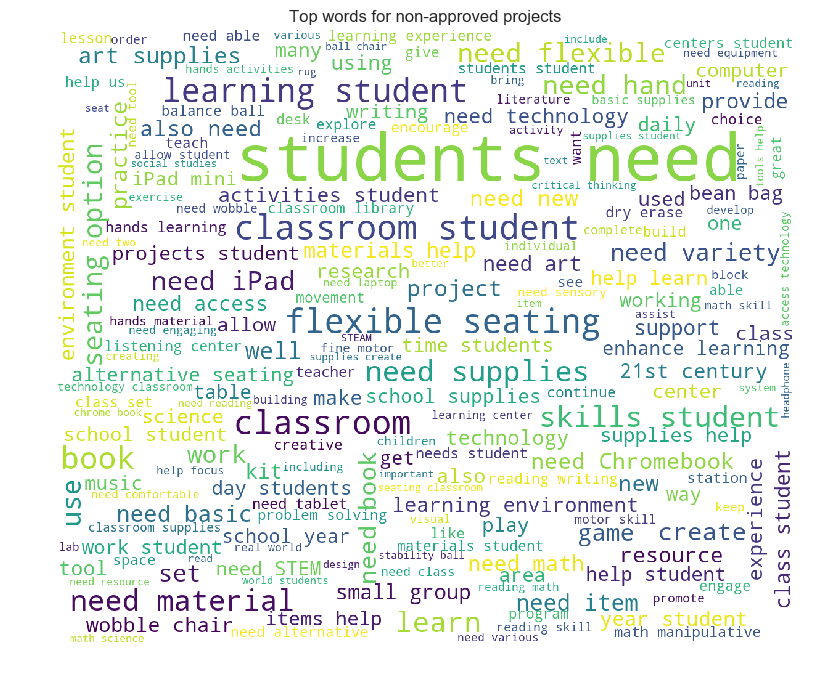

In [539]:
text = ' '.join(train.loc[train['project_is_approved'] == 0, 'project_resource_summary'].values)
wordcloud = WordCloud(max_font_size=None, stopwords=stop, background_color='white',
                      width=1200, height=1000).generate(text);
plt.figure(figsize=(12, 8));
plt.imshow(wordcloud);
plt.title('Top words for non-approved projects');
plt.axis("off");
plt.show();

## Project Title

In [571]:
train.project_title[:5]

0                             Super Sight Word Centers
1                               Keep Calm and Dance On
2                                Lets 3Doodle to Learn
3    \"Kid Inspired\" Equipment to Increase Activit...
4     We need clean water for our culinary arts class!
Name: project_title, dtype: object

In [572]:
text = ' '.join(train.project_title.values)
text = [i for i in ngrams(text.split(),3)]

In [573]:
Counter(text).most_common(20)

[(('Flexible', 'Seating', 'for'), 1181),
 (('in', 'the', 'Classroom'), 657),
 (('Wiggle', 'While', 'We'), 452),
 (('Our', 'Way', 'to'), 393),
 (('Wiggle', 'While', 'You'), 383),
 (('Like', 'to', 'Move'), 362),
 (('We', 'Like', 'to'), 356),
 (('Move', 'It,', 'Move'), 354),
 (('Read', 'All', 'About'), 327),
 (('Can', 'You', 'Hear'), 321),
 (('Technology', 'in', 'the'), 319),
 (('While', 'We', 'Work'), 293),
 (('the', '21st', 'Century'), 287),
 (('While', 'We', 'Work!'), 273),
 (('to', 'Move', 'It,'), 267),
 (('All', 'About', 'It!'), 258),
 (('Flexible', 'Seating', 'in'), 252),
 (('While', 'You', 'Work'), 252),
 (('the', 'Love', 'of'), 236),
 (('in', 'Need', 'of'), 230)]

In [574]:
text[:10]

[('Super', 'Sight', 'Word'),
 ('Sight', 'Word', 'Centers'),
 ('Word', 'Centers', 'Keep'),
 ('Centers', 'Keep', 'Calm'),
 ('Keep', 'Calm', 'and'),
 ('Calm', 'and', 'Dance'),
 ('and', 'Dance', 'On'),
 ('Dance', 'On', 'Lets'),
 ('On', 'Lets', '3Doodle'),
 ('Lets', '3Doodle', 'to')]

In [575]:
print("Title:", "Flexible Seating in")
#give me every project resource summary where the project title is 'Wiggle..."
train.loc[train.project_title == "Wiggle While You Work","project_resource_summary"].values[:3]

Title: Flexible Seating in


array(['My students need seating options that offer choice beyond traditional desks.',
       'My students need 10 Wobble Chairs to help them wiggle while working.',
       'My students need these exercise balls as an outlet during small group instruction. From my experience students learn in a variety of ways.'],
      dtype=object)

## teacher prefix

In [576]:
train.teacher_prefix.nunique()

6

In [577]:
train.teacher_prefix.value_counts(dropna=False)

Mrs.       95405
Ms.        65066
Mr.        17667
Teacher     3912
Dr.           26
Mrs            4
Name: teacher_prefix, dtype: int64

In [578]:
pd.crosstab(train.teacher_prefix,train.project_is_approved,dropna=False,normalize='index')

project_is_approved,0,1
teacher_prefix,,
Dr.,0.192308,0.807692
Mr.,0.157978,0.842022
Mrs,0.000000,1.000000
Mrs.,0.145915,0.854085
Ms.,0.156948,0.843052
Teacher,0.205777,0.794223


In [579]:
train.teacher_prefix.fillna('Mrs',inplace=True)

## School state

In [580]:
train.groupby('school_state').agg({'project_is_approved': ['mean', 'count']}).reset_index().sort_values([('project_is_approved', 'mean')], ascending=False).reset_index(drop=True)

school_state project_is_approved       
                               mean  count
0            DE            0.891341    589
1            WY            0.875706    177
2            OH            0.871467   4139
3            CT            0.871294   2766
4            WA            0.868050   3903
5            WV            0.867700    839
6            NH            0.867121    587
7            ND            0.866935    248
8            SC            0.864923   6463
9            SD            0.862348    494
10           MA            0.860138   4054
11           ME            0.858525    827
12           KY            0.857735   2172
13           MO            0.857547   4247
14           MN            0.857421   2055
15           NV            0.856770   2297
16           CA            0.856431  25695
17           OR            0.855592   2119
18           VA            0.855194   3446
19           IL            0.853792   7332
20           NY            0.853582  12157
21           NC            0.853480   8463
22           KS            0.852830   1060
23           PA            0.852543   5093
24           NE            0.851927    493
25           TN            0.851904   2836
26           AK            0.849192    557
27           VT            0.848921    139
28           AL            0.848393   2955
29           IN            0.847937   4314
30           IA            0.846154   1079
31           CO            0.845787   1887
32           WI            0.845122   2983
33           MI            0.844478   5324
34           RI            0.844211    475
35           HI            0.843498    869
36           MS            0.843384   2222
37           NJ            0.843367   3671
38           ID            0.841869   1113
39           AZ            0.841727   3614
40           MD            0.836290   2480
41           UT            0.835110   2814
42           OK            0.834422   3829
43           GA            0.834087   6636
44           LA            0.834009   3946
45           AR            0.832100   1757
46           MT            0.828125    384
47           FL            0.824500  10359
48           NM            0.822052    916
49           TX            0.815670  12304
50           DC            0.812639    902

## project_submitted_datetime

In [581]:
type(train.iloc[0].project_submitted_datetime)

pandas._libs.tslib.Timestamp

In [582]:
train['date'] = train.project_submitted_datetime.dt.date
train['weekday'] = train.project_submitted_datetime.dt.weekday
train['day'] = train.project_submitted_datetime.dt.day
count_by_date = train.groupby('date')['project_is_approved'].count()
mean_by_date = train.groupby('date')['project_is_approved'].mean()


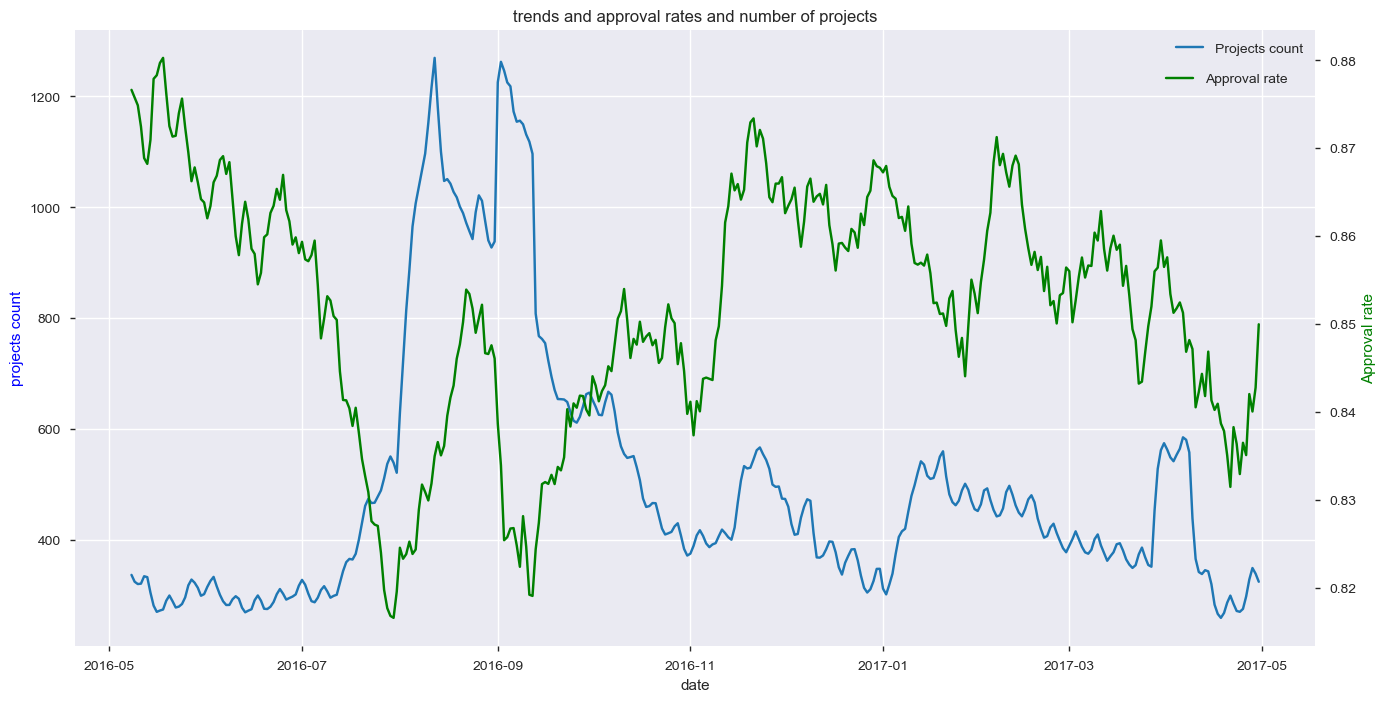

In [583]:
fig,ax1 = plt.subplots(figsize=(16,8))
plt.title("trends and approval rates and number of projects")
count_by_date.rolling(window=12,center=False).mean().plot(ax=ax1,legend=False);
ax1.set_ylabel('projects count',color='b');
plt.legend(['Projects count']);
ax2 = ax1.twinx()
mean_by_date.rolling(window=12,center=False).mean().plot(ax=ax2, color='g', legend=False);
ax2.set_ylabel('Approval rate', color='g');
plt.legend(['Approval rate'], loc=(0.875, 0.9));
plt.grid(False);

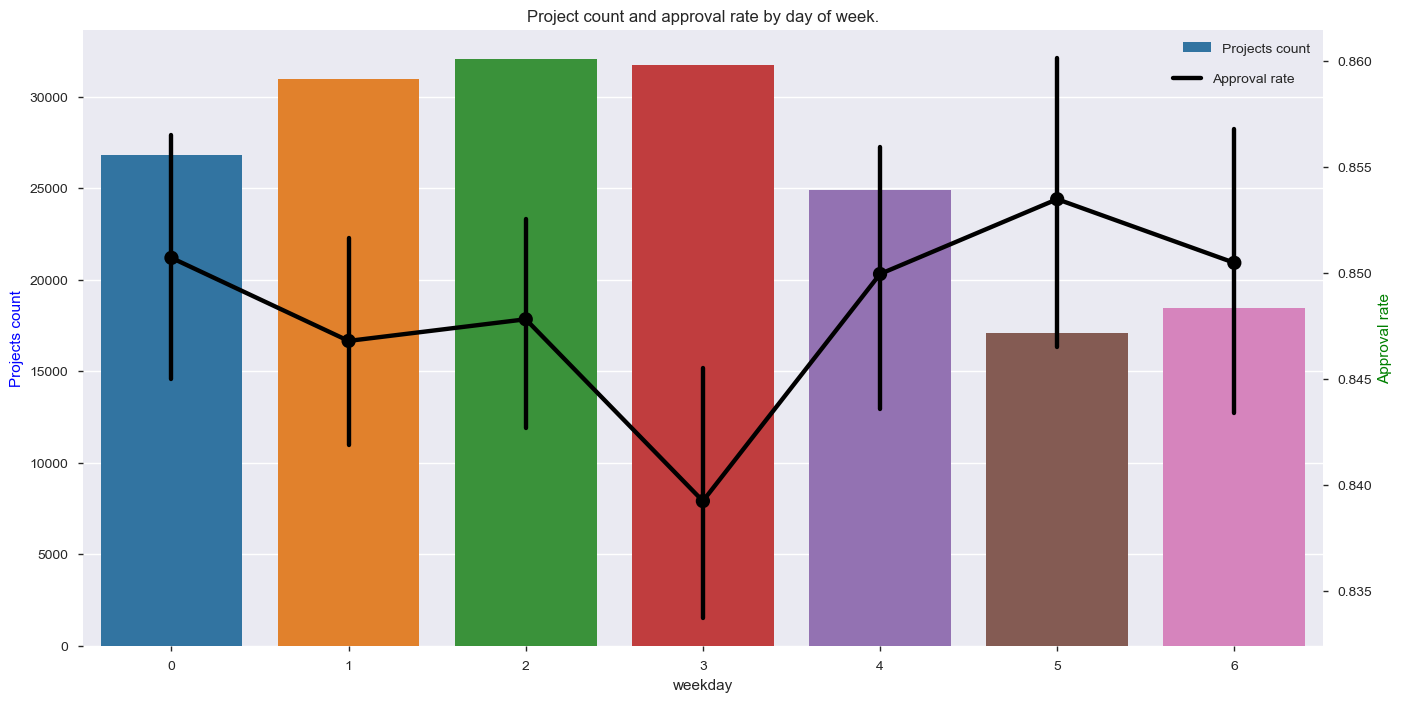

In [584]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Project count and approval rate by day of week.")
sns.countplot(x='weekday', data=train, ax=ax1)
ax1.set_ylabel('Projects count', color='b')
plt.legend(['Projects count'])
ax2 = ax1.twinx()
sns.pointplot(x="weekday", y="project_is_approved", data=train, ci=99, ax=ax2, color='black')
ax2.set_ylabel('Approval rate', color='g');
plt.legend(['Approval rate'], loc=(0.875, 0.9));
plt.grid(False);

## project grade category

In [585]:
pd.crosstab(train.project_grade_category,train.project_is_approved,dropna=False,normalize='index')

project_is_approved,0,1
project_grade_category,,
Grades 3-5,0.146023,0.853977
Grades 6-8,0.156541,0.843459
Grades 9-12,0.164764,0.835236
Grades PreK-2,0.152876,0.847124


## project subject categories and sub categories

In [586]:
train.project_subject_categories.values
train.project_subject_subcategories.values

array(['Literacy & Language', 'Music & The Arts, Health & Sports',
       'Math & Science, Literacy & Language', ..., 'Math & Science',
       'Literacy & Language', 'Literacy & Language'], dtype=object)

array(['Literacy', 'Performing Arts, Team Sports',
       'Applied Sciences, Literature & Writing', ...,
       'Applied Sciences, Environmental Science', 'Literacy', 'Literacy'],
      dtype=object)

In [587]:
psc = [i.split(', ') for i in train.project_subject_categories.values]
psc = [i for j in psc for i in j]
print("Common subject categories")
Counter(psc).most_common()
    

Common subject categories


[('Literacy & Language', 86988),
 ('Math & Science', 69248),
 ('Health & Sports', 23712),
 ('Special Needs', 22881),
 ('Applied Learning', 20303),
 ('Music & The Arts', 17054),
 ('History & Civics', 9726),
 ('Warmth', 2327),
 ('Care & Hunger', 2327)]

In [588]:
pssc = [i.split(', ') for i in train.project_subject_subcategories.values]
pssc = [i for j in pssc for i in j]
print("Common subject sub categories")
Counter(pssc).most_common()

Common subject sub categories


[('Literacy', 56066),
 ('Mathematics', 46884),
 ('Literature & Writing', 36974),
 ('Special Needs', 22881),
 ('Applied Sciences', 17966),
 ('Health & Wellness', 17099),
 ('Visual Arts', 10399),
 ('Environmental Science', 9436),
 ('Gym & Fitness', 7592),
 ('Health & Life Science', 7175),
 ('ESL', 7162),
 ('Early Development', 7149),
 ('History & Geography', 5258),
 ('Music', 5172),
 ('College & Career Prep', 4291),
 ('Other', 3948),
 ('Team Sports', 3643),
 ('Character Education', 3519),
 ('Performing Arts', 3223),
 ('Social Sciences', 3149),
 ('Warmth', 2327),
 ('Care & Hunger', 2327),
 ('Nutrition Education', 2236),
 ('Foreign Languages', 1496),
 ('Extracurricular', 1332),
 ('Civics & Government', 1294),
 ('Parent Involvement', 1103),
 ('Financial Literacy', 956),
 ('Community Service', 712),
 ('Economics', 431)]

## teacher_number_of_previously_posted_projects

In [589]:
test1 = train.groupby('teacher_number_of_previously_posted_projects')['project_is_approved'].mean()
test1[::20]

teacher_number_of_previously_posted_projects
0      0.819342
20     0.878704
40     0.912181
60     0.928571
80     0.966667
100    0.923077
120    0.919355
140    0.914286
160    0.909091
180    0.909091
200    0.909091
220    1.000000
240    1.000000
260    0.750000
280    1.000000
300    1.000000
320    1.000000
342    1.000000
366    1.000000
404    1.000000
451    1.000000
Name: project_is_approved, dtype: float64

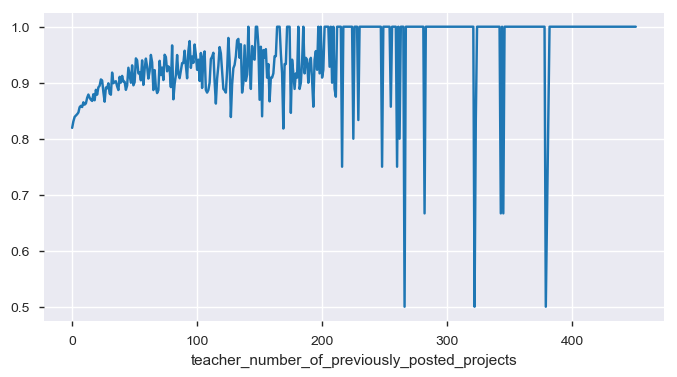

In [590]:
test1.plot(figsize=(8,4));

## Resources

In [591]:
resources.head(2)

,id,description,quantity,price,cost
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95,44.85


In [592]:
resources['cost'] = resources['quantity']*resources['price']
resources_aggregated = resources.groupby('id').agg({'description':['nunique'],'quantity':['sum'],'cost':['mean','sum']})

In [593]:
resources_aggregated[:5]

description quantity        cost         
            nunique      sum        mean      sum
id                                               
p000001           4        7  208.407500   833.63
p000002          14       21   45.020000   630.28
p000003           4        4   74.742500   298.97
p000004          93       98   11.854947  1126.22
p000005           2        8  175.577500   702.31

In [594]:
resources_aggregated.columns = ['unique_items', 'total_quantity', 'mean_cost', 'total_cost']
resources_aggregated.reset_index(inplace=True)
resources_aggregated.head()

,id,unique_items,total_quantity,mean_cost,total_cost
0,p000001,4,7,208.407500,833.63
1,p000002,14,21,45.020000,630.28
2,p000003,4,4,74.742500,298.97
3,p000004,93,98,11.854947,1126.22
4,p000005,2,8,175.577500,702.31


99 percentile is 1829.9.


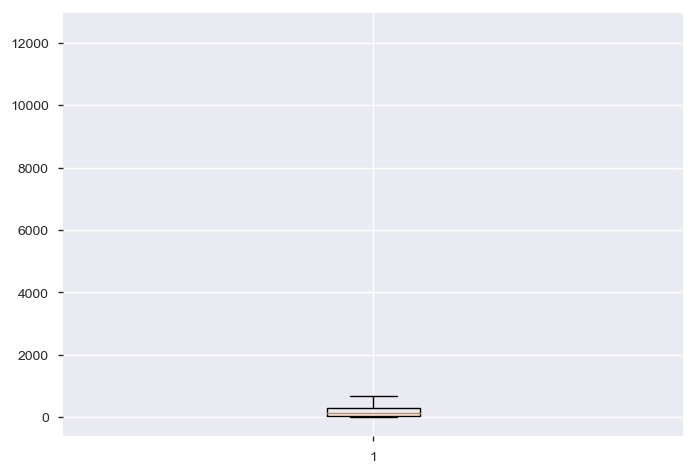

In [595]:
print('99 percentile is {0}.'.format(np.percentile(resources_aggregated.mean_cost, 99)))
plt.boxplot(resources_aggregated.mean_cost);

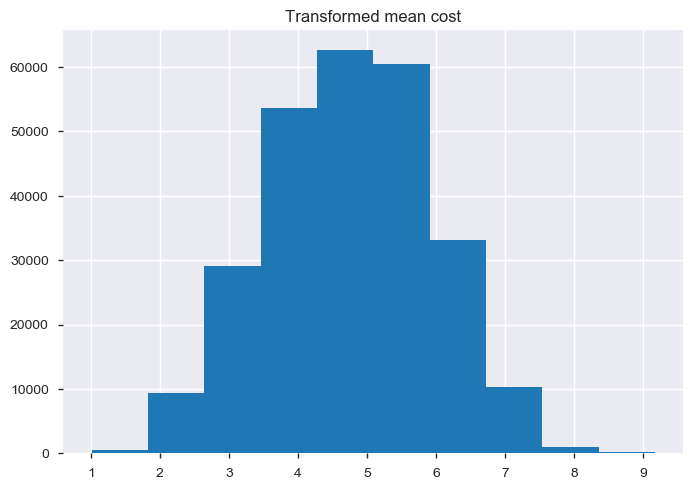

In [596]:
resources_aggregated['mean_cost'] = stats.boxcox(resources_aggregated.mean_cost + 1)[0]
plt.hist(resources_aggregated.mean_cost);
plt.title('Transformed mean cost');

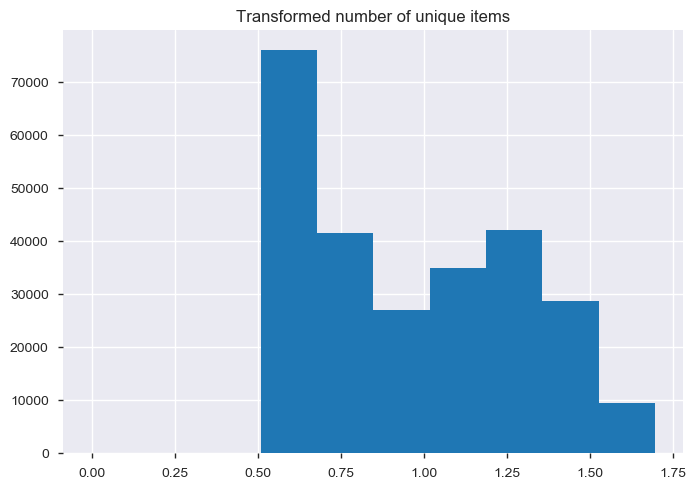

In [597]:
resources_aggregated['unique_items'] = stats.boxcox(resources_aggregated.unique_items + 1)[0]
plt.hist(resources_aggregated.unique_items);
plt.title('Transformed number of unique items');


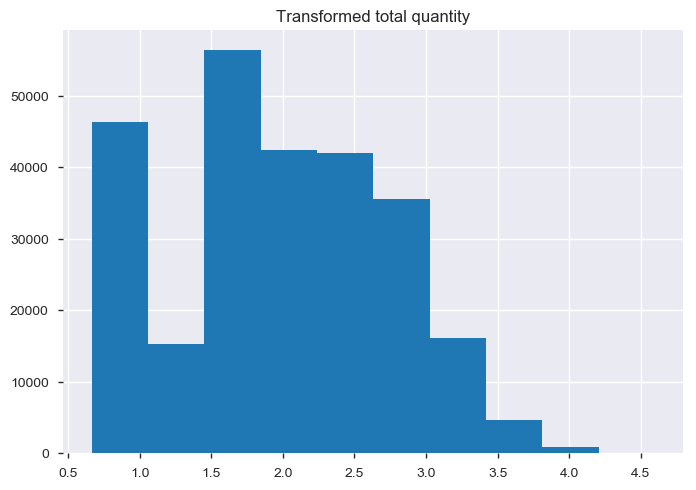

In [598]:
resources_aggregated['total_quantity'] = stats.boxcox(resources_aggregated.total_quantity + 1)[0]
plt.hist(resources_aggregated.total_quantity);
plt.title('Transformed total quantity');

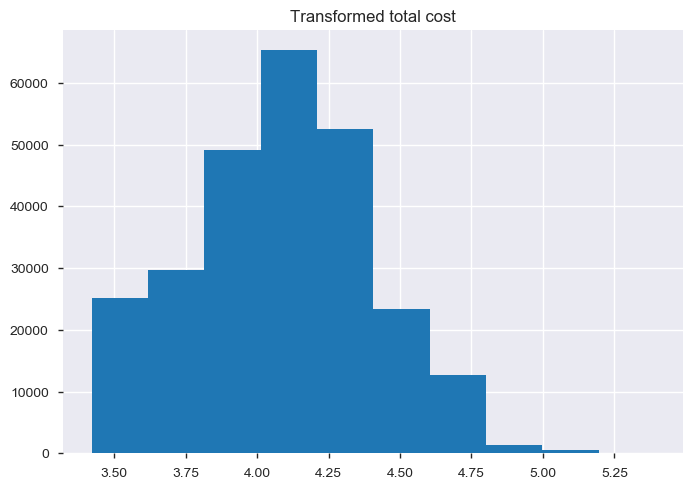

In [599]:
resources_aggregated['total_cost'] = stats.boxcox(resources_aggregated.total_cost + 1)[0]
plt.hist(resources_aggregated.total_cost);
plt.title('Transformed total cost');

In [600]:
#merge the train and test data resources
resources_aggregated.head()

,id,unique_items,total_quantity,mean_cost,total_cost
0,p000001,1.074275,1.831636,5.264589,4.395813
1,p000002,1.420730,2.564878,3.788050,4.282509
2,p000003,1.074275,1.458175,4.274990,3.958563
3,p000004,1.689213,3.497525,2.535437,4.513009
4,p000005,0.828076,1.921844,5.099047,4.326865


In [601]:
train = pd.merge(train,resources_aggregated,how='left',on='id')
test = pd.merge(test,resources_aggregated,how='left',on='id')

## Apply to test

In [602]:
# Applying the same feature transformation to test.
test.loc[test.project_submitted_datetime.dt.date < datetime.date(2016, 5, 7), 'project_essay_1'] = test.loc[test.project_submitted_datetime.dt.date < datetime.date(2016, 5, 7), 'project_essay_1'] + ' ' + test.loc[test.project_submitted_datetime.dt.date < datetime.date(2016, 5, 7), 'project_essay_2']
test.loc[test.project_submitted_datetime.dt.date < datetime.date(2016, 5, 7), 'project_essay_2'] = test.loc[test.project_submitted_datetime.dt.date < datetime.date(2016, 5, 7), 'project_essay_3'] + ' ' + test.loc[test.project_submitted_datetime.dt.date < datetime.date(2016, 5, 7), 'project_essay_4']
test.drop(['project_essay_3', 'project_essay_4'], axis=1, inplace=True)

test['project_essay_1'] = test['project_essay_1'].apply(lambda x: x.replace('\\r', ' ').replace('\\n', ' ').replace('  ', ' '))
test['project_essay_2'] = test['project_essay_2'].apply(lambda x: x.replace('\\r', ' ').replace('\\n', ' ').replace('  ', ' '))

test['project_resource_summary'] = test['project_resource_summary'].apply(lambda x: x.replace('\\r', ' ').replace('\\n', ' ').replace('  ', ' '))
test['project_title'] = test['project_title'].apply(lambda x: x.replace('\\r', ' ').replace('\\n', ' ').replace('  ', ' '))
test['teacher_prefix'].fillna('Mrs.', inplace=True)

test['weekday'] = test.project_submitted_datetime.dt.weekday
test['day'] = test.project_submitted_datetime.dt.day

# Also dropping date from train.
train.drop('date', axis=1, inplace=True)

## Categorical Data

In [603]:
#teacher_prefix, project_grade_category, weekday and school_state.  First three have small number of unique values, 
#so we can use one hot encoding

#test = pd.get_dummies(train['teacher_prefix'])
#test[:5]

train = pd.concat([train,
                  pd.get_dummies(train['teacher_prefix'], drop_first=True),
                  pd.get_dummies(train['project_grade_category'], drop_first=True),
                  pd.get_dummies(train['weekday'],drop_first=True)],axis=1)
train.drop(['teacher_prefix','project_grade_category','weekday'],axis=1, inplace=True)

test = pd.concat([test,
                  pd.get_dummies(test['teacher_prefix'], drop_first=True),
                  pd.get_dummies(test['project_grade_category'], drop_first=True),
                  pd.get_dummies(test['weekday'],drop_first=True)],axis=1)
test.drop(['teacher_prefix','project_grade_category','weekday'],axis=1, inplace=True)
          

In [604]:
#school state has many unique values, lets try target encoding.

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    
    https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return ft_trn_series, ft_tst_series

In [605]:
train['school_state'], test['school_state'] = target_encode(train['school_state'], test['school_state'], train['project_is_approved'])

In [606]:
train.school_state[:5]

0    0.856770
1    0.834087
2    0.835110
3    0.853480
4    0.856431
Name: school_state, dtype: float64

## Text Data

In [607]:
#create new features based on length of text and number of words
train['len_project_subject_categories'] = train['project_subject_categories'].apply(lambda x: len(x))
train['words_project_subject_categories'] = train['project_subject_categories'].apply(lambda x: len(x.split()))
train['len_project_subject_subcategories'] = train['project_subject_subcategories'].apply(lambda x: len(x))
train['words_project_subsubject_categories'] = train['project_subject_subcategories'].apply(lambda x: len(x.split()))
train['len_project_title'] = train['project_title'].apply(lambda x: len(x))
train['words_project_title'] = train['project_title'].apply(lambda x: len(x.split()))
train['len_project_resource_summary'] = train['project_resource_summary'].apply(lambda x: len(x))
train['words_project_resource_summary'] = train['project_resource_summary'].apply(lambda x: len(x.split()))
train['len_project_essay_1'] = train['project_essay_1'].apply(lambda x: len(x))
train['words_project_essay_1'] = train['project_essay_1'].apply(lambda x: len(x.split()))
train['len_project_essay_2'] = train['project_essay_2'].apply(lambda x: len(x))
train['words_project_essay_2'] = train['project_essay_2'].apply(lambda x: len(x.split()))

test['len_project_subject_categories'] = test['project_subject_categories'].apply(lambda x: len(x))
test['words_project_subject_categories'] = test['project_subject_categories'].apply(lambda x: len(x.split()))
test['len_project_subject_subcategories'] = test['project_subject_subcategories'].apply(lambda x: len(x))
test['words_project_subsubject_categories'] = test['project_subject_subcategories'].apply(lambda x: len(x.split()))
test['len_project_title'] = test['project_title'].apply(lambda x: len(x))
test['words_project_title'] = test['project_title'].apply(lambda x: len(x.split()))
test['len_project_resource_summary'] = test['project_resource_summary'].apply(lambda x: len(x))
test['words_project_resource_summary'] = test['project_resource_summary'].apply(lambda x: len(x.split()))
test['len_project_essay_1'] = test['project_essay_1'].apply(lambda x: len(x))
test['words_project_essay_1'] = test['project_essay_1'].apply(lambda x: len(x.split()))
test['len_project_essay_2'] = test['project_essay_2'].apply(lambda x: len(x))
test['words_project_essay_2'] = test['project_essay_2'].apply(lambda x: len(x.split()))

In [608]:
#Start transforming the text

vectorizer=TfidfVectorizer(min_df=3,max_features=None,
                          strip_accents='unicode',analyzer='word',token_pattern=r'\w{1,}',
                          ngram_range=(1,2),use_idf=1,smooth_idf=1,sublinear_tf=1,stop_words='english');

vectorizer.fit(train['project_subject_categories']);
train_project_subject_categories = vectorizer.transform(train['project_subject_categories']);
test_project_subject_categories = vectorizer.transform(test['project_subject_categories']);

vectorizer.fit(train['project_subject_subcategories']);
train_project_subject_subcategories = vectorizer.transform(train['project_subject_subcategories']);
test_project_subject_subcategories = vectorizer.transform(test['project_subject_subcategories']);

In [609]:
#limit the output for real texts 

vectorizer=TfidfVectorizer(min_df=3,max_features=1000,
                          strip_accents='unicode',analyzer='word',token_pattern=r'\w{1,}',
                          ngram_range=(1,2),use_idf=1,smooth_idf=1,sublinear_tf=1,stop_words='english');

vectorizer.fit(train['project_title']);
train_project_title = vectorizer.transform(train['project_title']);
test_project_title = vectorizer.transform(test['project_title']);

vectorizer.fit(train['project_resource_summary']);
train_project_resource_summary = vectorizer.transform(train['project_resource_summary']);
test_project_resource_summary = vectorizer.transform(test['project_resource_summary']);

In [610]:
vectorizer=TfidfVectorizer(min_df=3,max_features=1000,
                          strip_accents='unicode',analyzer='word',token_pattern=r'\w{1,}',
                          ngram_range=(1,2),use_idf=1,smooth_idf=1,sublinear_tf=1,stop_words='english');

vectorizer.fit(train['project_essay_1']);
train_project_essay_1 = vectorizer.transform(train['project_essay_1']);
test_project_essay_1 = vectorizer.transform(test['project_essay_1']);

vectorizer.fit(train['project_essay_2']);
train_project_essay_2 = vectorizer.transform(train['project_essay_2']);
test_project_essay_2 = vectorizer.transform(test['project_essay_2']);

## Normalization of continuous variables

In [611]:
cols_to_normalize = ['teacher_number_of_previously_posted_projects', 'len_project_subject_categories',
                     'words_project_subject_categories', 'len_project_subject_subcategories',
                     'words_project_subsubject_categories', 'len_project_title', 'words_project_title',
                     'len_project_resource_summary', 'words_project_resource_summary',
                     'len_project_essay_1', 'words_project_essay_1', 'len_project_essay_2', 'words_project_essay_2'];
scaler = StandardScaler();
for col in cols_to_normalize:
    scaler.fit(train[col].values.reshape(-1, 1));
    train[col] = scaler.transform(train[col].values.reshape(-1, 1));
    test[col] = scaler.transform(test[col].values.reshape(-1, 1));

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [612]:
#drop unecessary columns

to_drop = ['teacher_id', 'school_state', 'project_submitted_datetime', 'project_subject_categories', 'project_subject_subcategories', 'project_title', 'project_essay_1', 'project_essay_2', 'project_resource_summary']
for col in to_drop:
    train.drop([col], axis=1, inplace=True)
    test.drop([col], axis=1, inplace=True)

In [613]:
X = train.drop(['id', 'project_is_approved'], axis=1)
y = train['project_is_approved']
X_test = test.drop('id', axis=1)

## Stack features and fit

In [614]:
#stack the features

X_full = csr_matrix(hstack([X.values, train_project_subject_categories, train_project_subject_subcategories, train_project_resource_summary, train_project_essay_1, train_project_essay_2]))
X_test_full = csr_matrix(hstack([X_test.values, test_project_subject_categories, test_project_subject_subcategories, test_project_resource_summary, test_project_essay_1, test_project_essay_2]))


In [615]:
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y, test_size=0.20, random_state=42)

In [616]:
# Delete unnecessary data to free memory.
del train_project_subject_categories
del train_project_subject_subcategories
del train_project_resource_summary
del train_project_essay_1
del train_project_essay_2
del test_project_subject_categories
del test_project_subject_subcategories
del test_project_resource_summary
del test_project_essay_1
del test_project_essay_2
del X_full

In [617]:
#These parameters can be tuned for performance increase

params = {'eta': 0.05, 'max_depth': 5, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'seed': 42, 'silent': False, 'colsample':0.9}
watchlist = [(xgb.DMatrix(X_train, y_train), 'train'), (xgb.DMatrix(X_valid, y_valid), 'valid')]
model = xgb.train(params, xgb.DMatrix(X_train, y_train), 100,  watchlist, verbose_eval=10, early_stopping_rounds=20)

[0]	train-auc:0.713782	valid-auc:0.707669
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[10]	train-auc:0.72848	valid-auc:0.718285
[20]	train-auc:0.733592	valid-auc:0.722746
[30]	train-auc:0.739422	valid-auc:0.727618
[40]	train-auc:0.745447	valid-auc:0.731885
[50]	train-auc:0.750687	valid-auc:0.735464
[60]	train-auc:0.756675	valid-auc:0.739463
[70]	train-auc:0.762438	valid-auc:0.742999
[80]	train-auc:0.767695	valid-auc:0.746201
[90]	train-auc:0.772444	valid-auc:0.748848
[99]	train-auc:0.775604	valid-auc:0.750615


In [ ]:
submission['project_is_approved'] = model.predict(xgb.DMatrix(X_test_full), ntree_limit=model.best_ntree_limit)
submission.to_csv('xgb_1.csv', index=False)